In [1]:
import cv2
import os
import csv

import torch
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob

import matplotlib.pyplot as plt

from torch.utils.data import Sampler
import random

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import train_test_split

In [2]:
session_epochs = (200, 100, 100)
dataset_sample_size = 0.15

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# This class stores a scan slice image and its associated mask
class ScanSlice:
    def __init__(self, file_path, shape, transform=None):
        self.file_path = file_path
        self.case = file_path.split('/')[-4]
        self.transform = transform
        self.shape = shape
        self.feature_data = None
        self.mask_count = 0

        # format the file name properly
        case_path = file_path.split('/')
        slice_name = case_path[-1].split('_')

        # name is the name in the train.csv file
        # original shape is the shape of the raw image before transform
        self.name = f"{case_path[-3]}_slice_{slice_name[1]}"
        self.original_shape = (int(slice_name[3]), int(slice_name[2]))

        # apply a default mask
        self.mask = np.zeros(self.shape, dtype=np.uint8)

        # init the mask values that we will use
        self.mask_values = {"large_bowel": 1, "small_bowel": 2, "stomach": 3}

    def features(self, device="cpu", dtype=torch.float):
        return self.feature_data

    def decode_rle(self, rle, label):
        # make sure the rle is not empty
        if not rle or (type(rle) is not str and np.isnan(rle)) or rle.strip() == "":
            return

        self.mask_count += 1
        s = list(map(int, rle.strip().split()))
        starts, lengths = s[::2], s[1::2]
        starts = np.array(starts)
        ends = starts + lengths

        mask = np.zeros(self.original_shape[0] * self.original_shape[1], dtype=np.uint8)
        for start, end in zip(starts, ends):
            mask[start:end] = 1

        mask = cv2.resize(mask.reshape(self.original_shape), self.shape, interpolation=cv2.INTER_NEAREST)
        self.mask[mask == 1] = self.mask_values[label]

    def load_slice(self, device="cpu", dtype=torch.float):
                # load image into memory
        img_data = cv2.imread(self.file_path, cv2.IMREAD_UNCHANGED)

        # format the data accordingly
        result = self.transform(img_data)
        result = result.to(dtype=dtype)
        result.to(device)
        self.feature_data = result
        


class MRIData(Dataset):
    def __init__(self, transform, slice_shape, device="cpu", from_scratch=True):
        self.slices = dict()
        self.slice_index = list()
        self.cases = set()
        self.device = device
        self.transform = transform
        self.slice_shape = slice_shape

        self.full = list()
        self.mixed = list()
        self.empty = list()
        if from_scratch:
            self.read_slice_data()
            self.read_rles()

        n_samples = int(len(self.slice_index) * dataset_sample_size)
        self.slice_index = self.slice_index[:n_samples]

        self.slices = dict()
        for sample in self.slice_index:
            self.slices[sample.name] = sample

        
        self.num_samples()
        

    def num_samples(self):
        self.sort_samples()
        for sample in self.slice_index:
            sample.load_slice()
        
        print(f"full samples: {len(self.full)}")
        print(f"mixed samples: {len(self.mixed)}")
        print(f"empty samples: {len(self.empty)}")
        
    def __getitem__(self, idx):
        if type(idx) == str:
            return self.slices[idx].features(device=self.device), self.slices[idx].mask.astype(np.int64)
        return self.slice_index[idx].features(device=self.device), self.slice_index[idx].mask.astype(np.int64)

    def __len__(self):
        return len(self.slices)

    def get_slice(self, idx):
        if type(idx) == str:
            return self.slices[idx]
        return self.slice_index[idx]

    def read_slice_data(self):
        # get all of the slice paths
        slices = glob(f"{os.getcwd()}/gi-tract-data/train/*/*/scans/slice_*")
        slices = [slice.replace("\\", "/") for slice in slices]

        # create a slice object for every slice
        for slice_path in slices:
            ss = ScanSlice(slice_path, self.slice_shape, self.transform)
            self.slice_index.append(ss)
            self.slices[ss.name] = ss

    def read_rles(self):
        # open the train.csv file
        train_csv_path = f"{os.getcwd()}/gi-tract-data/train.csv"
        rle_file = pd.read_csv(train_csv_path)

        # give each slice its rle
        for i in range(0, len(rle_file)):
            slice_name, label, rle = rle_file.iloc[i]
            self.slices[slice_name].decode_rle(rle, label)

    def sort_samples(self):
        for i in range(len(self.slices)):
            sample = self.get_slice(i)
            self.cases.add(sample.case)
            if sample.mask_count == 0:
                self.empty.append(i)
            elif sample.mask_count == 3:
                self.full.append(i)
            else:
                self.mixed.append(i)

    def get_case(self, cases):
        # get the slice names for a case
        case_slices = list()
        #for case in cases:
        for case in cases:
            for slice in self.slice_index:
                if slice.case == case:
                    case_slices.append(slice)
        # create a new dataset with only the slices from this case
        case_dataset = MRIData(self.transform, self.slice_shape, self.device, from_scratch=False)
        for slice in case_slices:
            case_dataset.slices[slice.name] = slice
        case_dataset.slice_index = case_slices
        return case_dataset

    def num_cases(self):
        return len(self.cases)
    
    def slices_per_case(self):
        slice_per_case = dict()
        for case in self.cases:
            slice_per_case[case] = len([slice for slice in self.slice_index if slice.case == case])
        return slice_per_case

    def approximate_percentage(self, percent):
        total = len(self.slice_index)
        slices_per_case = self.slices_per_case()
        
        subset = list()
        subset_size = 0
        for case in self.cases:
            subset_size += slices_per_case[case]
            subset.append(case)
            if subset_size >= total * percent:
                break
        remaining_cases = list(self.cases - set(subset))
        return subset, subset_size / total, remaining_cases, len(self.cases) - len(subset) / total


    def display_image_with_mask(self, idx):
        img, mask = self[idx]
        plt.figure()
        plt.imshow(img.squeeze(), cmap='gray')
        plt.imshow(mask, alpha=0.5)
        plt.axis('off')
        plt.show()

In [5]:
class BatchSampler(Sampler):
    def __init__(self, train_dataset, full, mixed, empty, batch_size, full_count, mixed_count, empty_count):
        self.full = full
        self.mixed = mixed
        self.none = empty
        self.batch_size = batch_size
        self.full_count = full_count
        self.partial_count = mixed_count
        self.none_count = empty_count
        self.dataset_len = len(train_dataset)

    def __iter__(self):
        batch = (
            random.sample(self.full, self.full_count) +
            random.sample(self.mixed, self.partial_count) +
            random.sample(self.none, self.none_count)
        )
        random.shuffle(batch)
        yield batch

    def __len__(self):
        return self.dataset_len // self.batch_size

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

mrid = MRIData(transform, (256, 256), device=device)

full samples: 470
mixed samples: 2170
empty samples: 3134


In [7]:
print(f"Number of slices: {len(mrid)}")
print(f"Number of cases: {mrid.num_cases()}")

Number of slices: 5774
Number of cases: 15


In [8]:
#Number of slices per case
print(f"Number of slices per case: {mrid.slices_per_case()}")

Number of slices per case: {'case107': 432, 'case111': 288, 'case102': 144, 'case101': 576, 'case119': 720, 'case121': 190, 'case114': 432, 'case110': 288, 'case116': 144, 'case108': 432, 'case115': 144, 'case11': 432, 'case117': 464, 'case118': 368, 'case113': 720}


In [9]:
train_cases = mrid.approximate_percentage(0.8)
print(f"Approximate percentage: {train_cases[1] * 100:.2f}%")

test_dataset = mrid.get_case(train_cases[2])
mrid = mrid.get_case(train_cases[0])
print(f"Number of training slices: {len(mrid)}")
mrid.num_samples()
print(f"Number of remaining slices: {len(test_dataset)}")
test_dataset.num_samples()

validation_cases = test_dataset.approximate_percentage(0.5)
print(f"Approximate percentage: {validation_cases[1] * 100:.2f}%")
val_dataset = test_dataset.get_case(validation_cases[0])
test_dataset = test_dataset.get_case(validation_cases[2])
print(f"Number of test slices: {len(test_dataset)}")
test_dataset.num_samples()
print(f"Number of val slices: {len(val_dataset)}")
val_dataset.num_samples()

Approximate percentage: 81.16%
full samples: 0
mixed samples: 0
empty samples: 0
full samples: 0
mixed samples: 0
empty samples: 0
Number of training slices: 4686
full samples: 406
mixed samples: 1718
empty samples: 2562
Number of remaining slices: 1088
full samples: 64
mixed samples: 452
empty samples: 572
Approximate percentage: 66.18%
full samples: 0
mixed samples: 0
empty samples: 0
full samples: 0
mixed samples: 0
empty samples: 0
Number of test slices: 368
full samples: 18
mixed samples: 180
empty samples: 170
Number of val slices: 720
full samples: 46
mixed samples: 272
empty samples: 402


In [10]:
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [11]:
def split_indices(indices, train_ratio=0.8, val_ratio=0.10, test_ratio=0.10, seed=42):
    train, temp = train_test_split(indices, test_size=(1 - train_ratio), random_state=seed)
    val, test = train_test_split(temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=seed)
    return train, val, test

full_train = mrid.full
partial_train = mrid.mixed
if len(mrid.empty) > 0:
    none_train = mrid.empty
else:
    none_train = list()
train_indices = full_train + partial_train + none_train

train_dataset = Subset(mrid, train_indices)

def get_train_loader_ratio(train_dataset, full_count, mixed_count, empty_count):
    full = list()
    mixed = list()
    empty = list()

    for i in range(len(train_indices)):
        if mrid.get_slice(train_indices[i]).mask_count == 3:
            full.append(i)
        elif mrid.get_slice(train_indices[i]).mask_count == 0:
            empty.append(i)
        else:
            mixed.append(i)
    sampler = BatchSampler(
    train_dataset=train_dataset,
    full=full,
    mixed=mixed,
    empty=empty,
    batch_size=16,
    full_count=full_count,
    mixed_count=mixed_count,
    empty_count=empty_count
    )
    return DataLoader(train_dataset, batch_sampler=sampler)


In [12]:
class DiceLoss(nn.Module):
    """
    Multi‑class Dice loss.
    Expects:
      - logits: (B, C, H, W) raw network outputs
      - targets: (B, H, W) integer class labels in [0..C-1]
    """
    def __init__(self, smooth: float = 1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Number of classes from logits shape
        num_classes = logits.shape[1]

        # Convert to probabilities
        probs = F.softmax(logits, dim=1)

        # One‑hot encode targets to shape (B, C, H, W)
        with torch.no_grad():
            targets_one_hot = F.one_hot(targets, num_classes)  # (B, H, W, C)
            targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        # Compute per‑class Dice score
        dims = (0, 2, 3)  # sum over batch & spatial dims
        intersection = torch.sum(probs * targets_one_hot, dims)
        cardinality  = torch.sum(probs + targets_one_hot, dims)
        dice_score   = (2. * intersection + self.smooth) / (cardinality + self.smooth)

        # Dice loss is 1 – mean Dice score across classes
        return 1. - dice_score.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha: float = 0.5, weight: torch.Tensor = None, ignore_index: int = -100):
        super().__init__()
        self.alpha = alpha
        self.ce    = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
        self.dice  = DiceLoss()

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        loss_ce   = self.ce(logits, targets)
        loss_dice = self.dice(logits, targets)
        return self.alpha * loss_ce + (1. - self.alpha) * loss_dice

In [13]:
# Define a double convolution block: (Conv -> BatchNorm -> ReLU) * 2
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Downsampling block: MaxPool then DoubleConv
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class BottleneckResBlock(nn.Module):
    def __init__(self, in_channels, dropout_prob=0.1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_prob),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(x + self.conv(x))

# Upsampling block: Upsample (or ConvTranspose2d) then DoubleConv.
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 is from the previous layer (decoder), x2 is from the encoder (skip connection)
        x1 = self.up(x1)
        # pad x1 if necessary to match dimensions of x2
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Final output convolution to reduce the number of channels to the desired number of classes.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [14]:
# this reduces memory problems with cuda
torch.cuda.empty_cache()

In [15]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.bottleneck = BottleneckResBlock(1024)
        self.up1 = Up(1536, 512)
        self.up2 = Up(768, 256)
        self.up3 = Up(384, 128)
        self.up4 = Up(192, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x5 = self.bottleneck(x5)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [16]:
model = UNet(n_channels=1, n_classes=4)
model.to(device)

criterion = CombinedLoss(alpha=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
def evaluate(model, val_loader):
    model.eval()
    val_loss = []
    for inputs, targets in val_loader:

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss.append(loss.detach())

    batch_losses = torch.stack(val_loss).mean().item()   
    return {'val_loss': batch_losses}

In [18]:
train_loader = get_train_loader_ratio(train_dataset, full_count=16, mixed_count=0, empty_count=0)


csv_file = open('ReluTrainingData1.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])

num_epochs = session_epochs[0]
history = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode.
    train_loss = 0.0
    train_losses = []
    for inputs, targets in train_loader:

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Move the data to the proper device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # do the training stuff
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()


    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    history.append(result)
    # Compute average training loss.
    #train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {result['train_loss']:.4f} - Val Loss: {result['val_loss']:.4f}")
    csv_writer.writerow([epoch+1, result['train_loss'], result['val_loss']])
csv_file.close()

C:\Users\Josh\AppData\Local\Temp\ipykernel_12044\1747783499.py:32: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  result['train_loss'] = torch.stack(train_losses).mean().item()


Epoch 1/200 - Train Loss: 0.8826 - Val Loss: 0.9196
Epoch 2/200 - Train Loss: 0.8634 - Val Loss: 0.9202
Epoch 3/200 - Train Loss: 0.8487 - Val Loss: 0.9196
Epoch 4/200 - Train Loss: 0.8473 - Val Loss: 0.9187
Epoch 5/200 - Train Loss: 0.8331 - Val Loss: 0.9172
Epoch 6/200 - Train Loss: 0.8201 - Val Loss: 0.9150
Epoch 7/200 - Train Loss: 0.8175 - Val Loss: 0.9125
Epoch 8/200 - Train Loss: 0.8172 - Val Loss: 0.9097
Epoch 9/200 - Train Loss: 0.8069 - Val Loss: 0.9063
Epoch 10/200 - Train Loss: 0.7972 - Val Loss: 0.9021
Epoch 11/200 - Train Loss: 0.7915 - Val Loss: 0.8972
Epoch 12/200 - Train Loss: 0.7875 - Val Loss: 0.8919
Epoch 13/200 - Train Loss: 0.7846 - Val Loss: 0.8869
Epoch 14/200 - Train Loss: 0.7814 - Val Loss: 0.8814
Epoch 15/200 - Train Loss: 0.7714 - Val Loss: 0.8753
Epoch 16/200 - Train Loss: 0.7648 - Val Loss: 0.8692
Epoch 17/200 - Train Loss: 0.7772 - Val Loss: 0.8640
Epoch 18/200 - Train Loss: 0.7637 - Val Loss: 0.8591
Epoch 19/200 - Train Loss: 0.7635 - Val Loss: 0.8523
Ep

In [19]:
# save the model
torch.save(model.state_dict(), 'relu_training_1.ai')

# load the model
model = UNet(n_channels=1, n_classes=4)
model.load_state_dict(torch.load('relu_training_1.ai'))
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [20]:
train_loader = get_train_loader_ratio(train_dataset, full_count=6, mixed_count=10, empty_count=0)
num_epochs = session_epochs[1]

csv_file = open('ReluTrainingData2.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode.
    train_loss = 0.0
    train_losses = []
    for inputs, targets in train_loader:

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Move the data to the proper device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # do the training stuff
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()


    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    history.append(result)
    # Compute average training loss.
    #train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {result['train_loss']:.4f} - Val Loss: {result['val_loss']:.4f}")
    csv_writer.writerow([epoch+1, result['train_loss'], result['val_loss']])
csv_file.close()

Epoch 1/100 - Train Loss: 0.6507 - Val Loss: 0.7554
Epoch 2/100 - Train Loss: 0.6392 - Val Loss: 0.7553
Epoch 3/100 - Train Loss: 0.6605 - Val Loss: 0.7554
Epoch 4/100 - Train Loss: 0.6266 - Val Loss: 0.7549
Epoch 5/100 - Train Loss: 0.6775 - Val Loss: 0.7549
Epoch 6/100 - Train Loss: 0.6071 - Val Loss: 0.7541
Epoch 7/100 - Train Loss: 0.6255 - Val Loss: 0.7534
Epoch 8/100 - Train Loss: 0.6216 - Val Loss: 0.7530
Epoch 9/100 - Train Loss: 0.6218 - Val Loss: 0.7526
Epoch 10/100 - Train Loss: 0.6565 - Val Loss: 0.7528
Epoch 11/100 - Train Loss: 0.6330 - Val Loss: 0.7527
Epoch 12/100 - Train Loss: 0.6568 - Val Loss: 0.7521
Epoch 13/100 - Train Loss: 0.6459 - Val Loss: 0.7514
Epoch 14/100 - Train Loss: 0.6560 - Val Loss: 0.7512
Epoch 15/100 - Train Loss: 0.6738 - Val Loss: 0.7513
Epoch 16/100 - Train Loss: 0.6084 - Val Loss: 0.7509
Epoch 17/100 - Train Loss: 0.6633 - Val Loss: 0.7513
Epoch 18/100 - Train Loss: 0.5907 - Val Loss: 0.7506
Epoch 19/100 - Train Loss: 0.5920 - Val Loss: 0.7501
Ep

In [21]:
# save the model
torch.save(model.state_dict(), 'relu_training_2.ai')


In [22]:
# load the model
model = UNet(n_channels=1, n_classes=4)
model.load_state_dict(torch.load('relu_training_2.ai'))
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [23]:
train_loader = get_train_loader_ratio(train_dataset, full_count=2, mixed_count=6, empty_count=8)
num_epochs = session_epochs[2]

csv_file = open('ReluTrainingData3.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode.
    train_loss = 0.0
    train_losses = []
    for inputs, targets in train_loader:

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Move the data to the proper device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # do the training stuff
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()


    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    history.append(result)
    # Compute average training loss.
    #train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {result['train_loss']:.4f} - Val Loss: {result['val_loss']:.4f}")
    csv_writer.writerow([epoch+1, result['train_loss'], result['val_loss']])
csv_file.close()

Epoch 1/100 - Train Loss: 0.6230 - Val Loss: 0.7514
Epoch 2/100 - Train Loss: 0.6844 - Val Loss: 0.7512
Epoch 3/100 - Train Loss: 0.7475 - Val Loss: 0.7515
Epoch 4/100 - Train Loss: 0.7226 - Val Loss: 0.7517
Epoch 5/100 - Train Loss: 0.6972 - Val Loss: 0.7514
Epoch 6/100 - Train Loss: 0.6894 - Val Loss: 0.7510
Epoch 7/100 - Train Loss: 0.6931 - Val Loss: 0.7507
Epoch 8/100 - Train Loss: 0.6975 - Val Loss: 0.7511
Epoch 9/100 - Train Loss: 0.6949 - Val Loss: 0.7516
Epoch 10/100 - Train Loss: 0.6902 - Val Loss: 0.7522
Epoch 11/100 - Train Loss: 0.7075 - Val Loss: 0.7526
Epoch 12/100 - Train Loss: 0.6987 - Val Loss: 0.7527
Epoch 13/100 - Train Loss: 0.6948 - Val Loss: 0.7521
Epoch 14/100 - Train Loss: 0.7369 - Val Loss: 0.7521
Epoch 15/100 - Train Loss: 0.6934 - Val Loss: 0.7516
Epoch 16/100 - Train Loss: 0.6976 - Val Loss: 0.7511
Epoch 17/100 - Train Loss: 0.6929 - Val Loss: 0.7518
Epoch 18/100 - Train Loss: 0.6867 - Val Loss: 0.7514
Epoch 19/100 - Train Loss: 0.6948 - Val Loss: 0.7509
Ep

In [24]:
# save the model
torch.save(model.state_dict(), 'relu_training_3.ai')

In [25]:

# load the model
model = UNet(n_channels=1, n_classes=4)
model.load_state_dict(torch.load('relu_training_3.ai'))
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

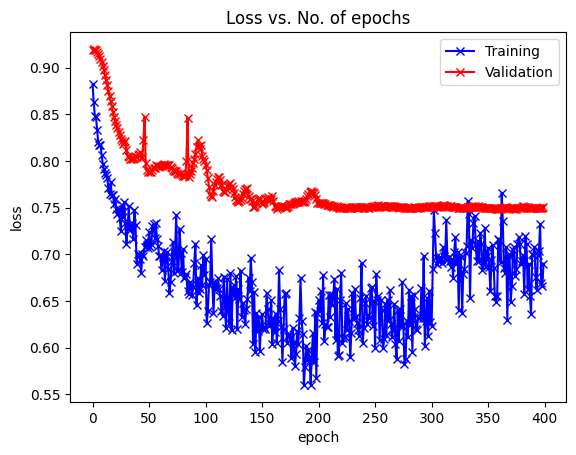

In [27]:
plot_losses(history)

In [28]:
def calculateIoU(gtMask, predMask):
    # Calculate the true positives,
    # false positives, and false negatives
    tp = 0
    fp = 0
    fn = 0

    for i in range(len(gtMask)):
        for j in range(len(gtMask[0])):
            if gtMask[i][j] == 1 and predMask[i][j] == 1:
                tp += 1
            elif gtMask[i][j] == 0 and predMask[i][j] == 1:
                fp += 1
            elif gtMask[i][j] == 1 and predMask[i][j] == 0:
                fn += 1

    # Calculate IoU
    iou = tp / (tp + fp + fn + 1e-6)  # Adding a small value to avoid division by zero

    return iou

In [29]:
#Predict on the test set
def predict(model, test_loader):
    iou = []
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        # Calculate IoU for each class
        for i in range(len(outputs)):
            pred_mask = outputs[i]
            gt_mask = targets[i].cpu().numpy()
            iou.append(calculateIoU(gt_mask, pred_mask))
    #Average IoU across all classes
    avg_iou = sum(iou) / len(iou)
    return avg_iou

In [30]:
iou = predict(model, test_loader)

In [31]:

print(f"Average IoU:", iou)

Average IoU: 0.2574150294700323


In [32]:
def display_image_with_mask(image: torch.tensor, mask: np.ndarray, alpha: float = 0.5):
    """
    Display a grayscale image with a binary mask overlaid.

    Parameters:
    - image: 2D tensor for a scan
    - mask:  2D numpy array of same shape with binary values (0 or 1).
    - alpha: float transparency for mask overlay.
    """
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, alpha=alpha)
    plt.axis('off')
    plt.show()

In [33]:
# errors with: case133_day25_slice_0049, All of day 77
X, y = mrid["case133_day25_slice_0049"]
print(len(mrid))

display_image_with_mask(X.squeeze(), y)

X_pred = X.unsqueeze(0).to(device)
y_pred = model(X_pred)

y_pred = torch.argmax(y_pred, dim=1)

y_print = y_pred.detach().cpu().numpy()
display_image_with_mask(X.squeeze(), y_print.squeeze())

KeyError: 'case133_day25_slice_0049'